In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots,CSV,DataFrames;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:

#https://github.com/fkguo/IMinuit.jl/blob/master/src/Data.jl
# check whether the data are valid for a fit
function check_data(xdata, ydata, errdata)
    if any(ismissing, xdata) || any(ismissing, ydata) || any(ismissing, errdata)
        error("Error: Data contain `missing` values.")
    end
    if any(isinf, xdata) || any(isinf, ydata) || any(isnan, xdata) || any(isnan, ydata) || any(isnan, errdata)
        error("Error: Data contain `Inf` or `NaN` values.")
    end
    if any(iszero, errdata)
        error("Error: Data contain 0 in the errors.")
    end
end

"""
    Data(x::T, y::T, err::T) where {T<:Vector{Real}}
    Data(df::DataFrame)
Fields: `x, y, err, ndata`
This defines a type for data with three columns:` x, y, err`; `ndata` is the number of data rows.
Different `Data` sets can be concatenated as `vcat(dat1, dat2, dat3)`.
Only symmetric errors (of `y`) are supported.
"""
struct Data
    x::Vector{Float64}
    y::Vector{Float64}
    err::Vector{Float64}
    ndata::Int
    function Data(x, y, err) # Data(x::Vector{T}, y::Vector{T}, err::Vector{T}) where {T<:Real}
        check_data(x, y, err)
        ndata = length(x)
        new(x, y, err, ndata)
    end
end

Data(df::DataFrame) = Data(df[:,1], df[:,2], df[:,3])

import Base.vcat, Base.getindex
vcat(dat1::Data, dat2::Data) = Data(vcat(dat1.x, dat2.x), vcat(dat1.y, dat2.y), vcat(dat1.err, dat2.err))
vcat(dat1::Data, dat...) = reduce(vcat, [dat1, dat...])
getindex(data::Data, in) = Data(map(x-> getindex(x, in), (data.x, data.y, data.err))...)

"""
    @plt_data(data, kws...)
    @plt_data!(data, kws...)
Convenient mascros to make an errorbar plot of the `data`; all combinations of
keyword settings for `scatter` in `Plots` can be used for the optional arguments `kws...`
"""
macro plt_data(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end
macro plt_data!(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter!($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter!($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end

@doc raw"""
    chisq(dist::Function, data, par; fitrange = ())
defines the ``\chi^2`` function: `fun` the function to be fitted to the data given by `data`.
The parameters are collected into `par`, given as an array or a tuple.
* `data` can be either given as the `Data` type, or of the form `(xdata, ydata [, err])`.
If no `err` is given explicitly, the errors are assumed to be 1 for all data points.
* `fitrange`: default to the whole data set; may given as, e.g., `2:10`,
which means only fitting to the 2nd to the 10th data points.
"""
function chisq(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
    end
    return res
end
# function chisq(dist::Function, data::Data, par::Tuple; fitrange = ())
#     fitrange = (isempty(fitrange) && 1:data.ndata)
#     res = 0.0
#     @simd for i = fitrange
#         @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
#     end
#     return res
# end
function chisq(dist::Function, data, par; fitrange = ())
    _x = data[1]; _y = data[2]
    _n = length(_x)
    _err = (length(data) == 2 ? ones(_n) : data[3])
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (_y[i]- dist(_x[i], par))/_err[i] )^2
    end
    return res
end

"""
    @plt_best(dist, fit, data, kws...)
    @plt_best!(dist, fit, data, kws...)
A convenient macro for comparing the best-fit result with the data; all combinations of
keyword settings for `plot` in `Plots` can be used for the optional arguments `kws...`
The ordering of `dist`, `fit`, and `data` does not matter.
"""
macro plt_best(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

macro plt_best!(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter!($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

quadgauss (generic function with 1 method)

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+2*length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [7]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))

dΓsmc (generic function with 1 method)

In [8]:
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [9]:
function getqw(E,Λ;ω=0.1,V0=-0.1,qi=qi,wi=wi)
    pmax=sqrt(abs(λf(E^2,mDn^2,(mπc+mDn)^2)))/(2*E)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    for i in eachindex(xxx)
        qi[2+i]=pmax*xxx[i]
        qi[2+len+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [10]:
getqw(mDn+mDsc-360e-6-im*24e-6,0.6)

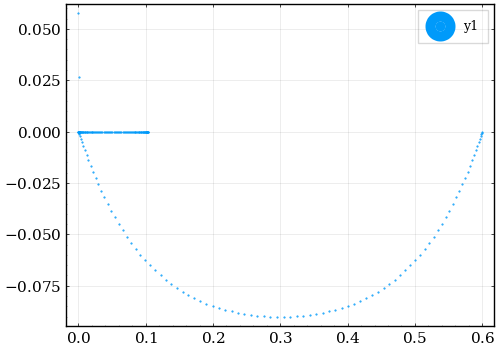

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [11]:
scatter(real.(qi[1:end]),imag.(qi[1:end]),markersize=0.5)

In [10]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [11]:
function VMat!(E;Λ=0.5,Cv = 0.0,Cp=0.0,I=0,plist=qi,des=Vmat)
    getqw(E,Λ)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DnDsc(E,plist[l], plist[m]; Cv=Cv,Cp=Cp,I=I)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m];  Cv=Cv,Cp=Cp,I=I)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m];  Cv=Cv,Cp=Cp,I=I)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DcDsn(E,plist[l], plist[m];  Cv=Cv,Cp=Cp,I=I)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [14]:
VMat!(3.875)

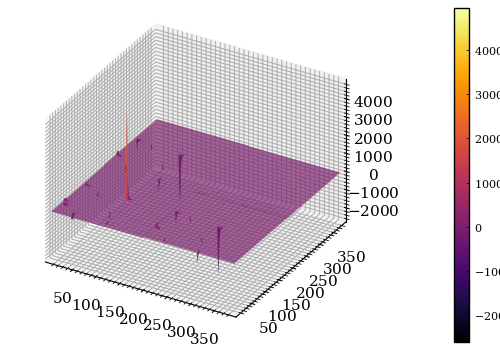

In [15]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

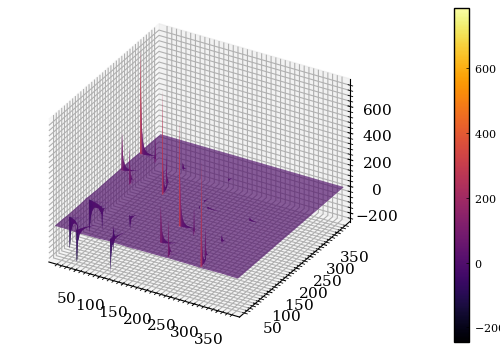

In [16]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [12]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [13]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gc(E,qi[2+len+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+len+j,(i-1)*sublen+2+len+j]=wi[j]*qi[2+len+j]^2*Gn(E,qi[2+len+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [14]:
function detVG(E;Λ=0.5,Cv=0.0,Cp=0.0,I=0)
    VMat!(E;Λ=Λ,Cv=Cv,Cp=Cp,I=I)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [15]:
function TMat!(E;Λ=0.5,Cv=0.0,Cp=0.0,I=0,des=Tmat)
    VMat!(E;Λ=Λ,Cv=Cv,Cp=Cp,I=I)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [21]:
@btime TMat!(3.875)

  74.018 ms (4672 allocations: 9.68 MiB)


In [22]:
let 
    function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
        TMat!(E;Λ=x[1],I=I)
        return 1/abs(Tmat[1,1])
    end
    
    tmpf(x)=inv_abst(x)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.2]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00019742905203882545
[0.3919058474670764]


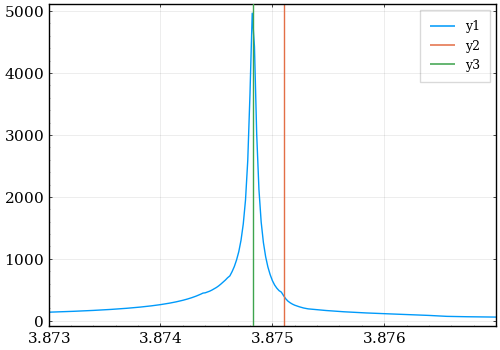

In [23]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;Λ=0.3919058474670764)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

# Extract pole position

In [16]:
function find_poles(pars)
    _lam,_Cv,_Cp=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,Cv=_Cv,Cp=_Cp)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, -24e-6])
    (tmp.zero[1]-mDn-mDsc)+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

In [25]:
find_poles([0.3919058474670764,0.0,0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, -2.4e-5]
 * Zero: [3.8748259659662523, -2.6153399025734125e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [26]:
3.8748259659662523-mDn-mDsc

-0.00027403403374792745

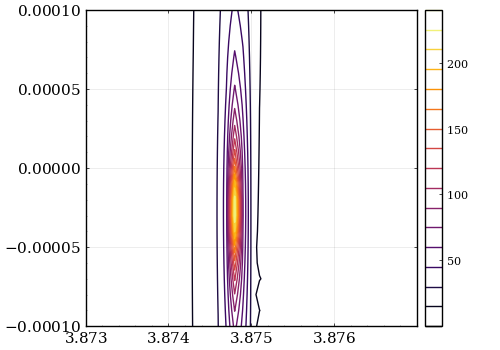

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [27]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.3919058474670764)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=false)
end

# Fitting

In [17]:
using Interpolations;

In [18]:
function maketmatrixf(E)
    tmatrix=zeros(ComplexF64,len)
    tmp=zero(ComplexF64)
    for k in 3:(2+len)
        tmp=1.0
        for i in eachindex(wi)
            tmp+=wi[i]*qi[2+len+i]^2*Gc(E,qi[2+len+i])*Tmat[k,2+len+i]
            tmp+=-wi[i]*qi[2+len+i]^2*Gn(E,qi[2+len+i])*Tmat[k,sublen+2+len+i]
        end
        tmatrix[k-2]=tmp
    end
    return LinearInterpolation(real.(qi[3:2+len]),tmatrix)
end

maketmatrixf (generic function with 1 method)

In [19]:
function Γ3f(E;Λ = 0.5,Cv=0.0,Cp=0.0)
     TMat!(E;Λ = Λ,Cv=Cv,Cp=Cp)

    res = 0.0
    μ1, μ2 = μf(mDn, mDsc), μf(mDc, mDsn)
    m1,m2,m3=mDn,mπc,mDn

    tmptmatrixf = maketmatrixf(E)
    tmatrixf(p) = (real(qi[3]) <= p && p <= real(qi[2+len])) ? tmptmatrixf(p) : 0.0
    for i in eachindex(xxx)
        for j in eachindex(xxx)
            x1, x2, w1, w2 = xxx[i], xxx[j], www[i], www[j]
            s23=(m2+m3)^2*(1-x1)+(E-m1)^2*x1
            s12_min=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)-sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12_max=m1^2+m2^2-(s23-E^2+m1^2)*(s23+m2^2-m3^2)/(2*s23)+sqrt(abs(λf(s23,E^2,m1^2)*λf(s23,m2^2,m3^2)))/(2*s23)
            s12=s12_min*(1-x2)+s12_max*x2
            q,qbar=sqrt(λf(s23,mπc^2,mDn^2))/(2*sqrt(s23)),sqrt(λf(s12,mDn^2,mπc^2))/(2*sqrt(s12))
            p,pbar=sqrt(λf(E^2,mDn^2,s23))/(2*E),sqrt(λf(E^2,mDn^2,s12))/(2*E)
            res+=w1*w2*abs((E-m1)^2-(m2+m3)^2)*abs(s12_max-s12_min)*abs(q*tmatrixf(p)*Gc(E,p)+qbar*tmatrixf(pbar)*Gc(E,pbar))^2
        end
    end
    return res
end

Γ3f (generic function with 1 method)

In [20]:
function Resolution(E, E1)
    σ1 = 1.05 * 263e-6
    σ2 = 2.413 * σ1
    α = 0.778
    gaussfunc(x, μ, σ) = 1 / sqrt(2 * π) / σ * exp(-(x - μ)^2 / (2 * σ^2))
    return α * gaussfunc(E, E1, σ1) + (1 - α) * gaussfunc(E, E1, σ2)
end

Resolution (generic function with 1 method)

## fitting

In [21]:
using PyCall;
import NLsolve;
piminuit=pyimport("iminuit");

In [22]:
let 
    data_ddπ_sub_df = DataFrame(CSV.File("./data/ddpi_sub_du.csv", header = ["x", "y"]));
    len=length(data_ddπ_sub_df.x)
    len1=Int64(len/3)
    xv=[3.8731+0.0002*(i-1) for i in 1:20]
    yv=[data_ddπ_sub_df.y[3*(i-1)+2] for i in 1:len1]
    wv=[abs(data_ddπ_sub_df.y[3*(i-1)+1]-data_ddπ_sub_df.y[3*(i-1)+3])/2 for i in 1:len1]
    global const data_ddπ_sub=Data(xv,yv,wv);
    nothing
end

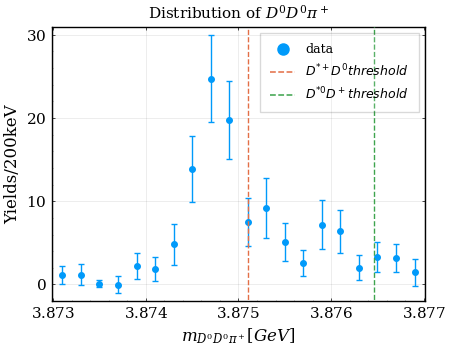

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.6056031611752245, 0.9786801175696073, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [23]:
@plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = "Yields/200keV" label = "data" size = (450, 350)
vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")

In [24]:
mutable struct distr
    Λ::Float64
    Cv::Float64
    Cp::Float64
    Γ3::Vector{Float64}
end

In [25]:
let Λ = 0.3919058474670764,Cv=0.0,Cp=0.0,Ev = range(3.873, 3.877, 100)
    resv = [Γ3f(e; Λ = Λ,Cv=Cv,Cp=Cp) for e in Ev]
    global distr_inst = distr(Λ,Cv,Cp, resv)
end

distr(0.3919058474670764, 0.0, 0.0, [0.0034027260913155363, 0.003697874812986638, 0.004021836992733997, 0.004377530907803514, 0.0047692515509833834, 0.005200842394746932, 0.005677872165174814, 0.006206118202678755, 0.0067913728047906624, 0.007441557832886541  …  0.6203749058682446, 0.6218677942424711, 0.665837966174314, 0.5881466879449245, 0.5670971307924184, 0.6316860402829345, 0.5790083498189411, 0.524958549114448, 0.5800249077950924, 0.5900880500356367])

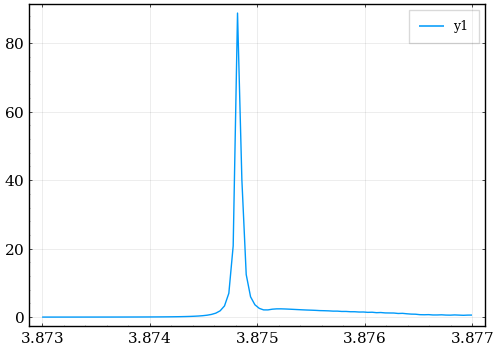

In [37]:
plot(range(3.873, 3.877, 100),distr_inst.Γ3)

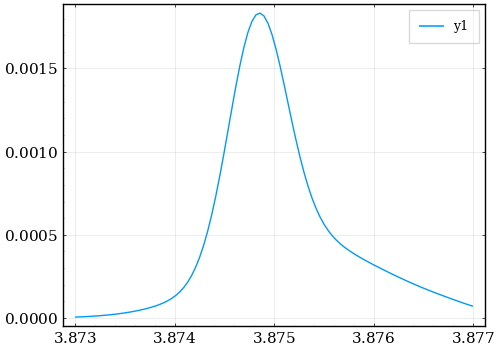

In [38]:
let
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, distr_inst.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xxx, www)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x 
    tmpf1(E)=quadgauss(x->ΔE*tmpf(Ebin(E,x)),xxx,www)
    plot(Ev,tmpf1.(Ev))
end

In [26]:
function remake_distr(dis::distr, Λ,Cv,Cp)
    if Λ ≈ dis.Λ&&Cv≈dis.Cv&&Cp≈dis.Cp
        return false
    else
        Ev = range(3.873, 3.877, 100)
        for i in eachindex(dis.Γ3)
            dis.Γ3[i] = Γ3f(Ev[i];Λ = Λ,Cv=Cv,Cp=Cp)
        end
        dis.Λ = Λ
        dis.Cv=Cv 
        dis.Cp=Cp
    end
    return true
end

remake_distr (generic function with 1 method)

In [27]:
function dist(E, pars; dis = distr_inst, xx = xxx, ww = www)
    N, Λ,Cv,Cp = pars
    remake_distr(dis, Λ,Cv,Cp)
    Ev = range(3.873, 3.877, 100)
    Emin, Emax = Ev[1], Ev[end]
    tmpΓ3f = LinearInterpolation(Ev, dis.Γ3)
    
    tmpf(E) = quadgauss(x ->(Emax - Emin) * tmpΓ3f(Emin + (Emax - Emin) * x) * Resolution(Emin + (Emax - Emin) * x, E), xx, ww)

    ΔE=0.0002
    Ebin(E,x)=(E-ΔE/2)*(1-x)+(E+ΔE/2)*x
    return N * quadgauss(x->ΔE*tmpf(Ebin(E,x)),xx,ww)
end

dist (generic function with 1 method)

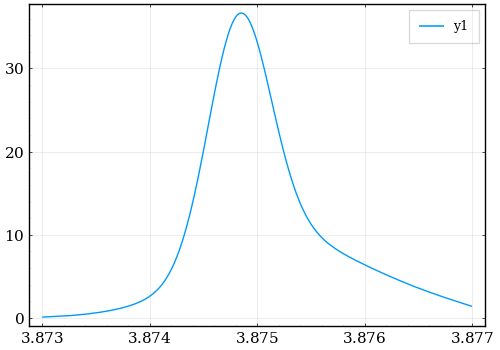

In [28]:
plot(e->dist(e,[1,0.3919058474670764,0.0,0.0])*30/0.0015,3.873,3.877)

In [29]:
fcn(x,y,z,l; fitrange = ()) = chisq(dist, data_ddπ_sub,[x,y,z,l]; fitrange = fitrange)

fcn (generic function with 1 method)

## fitting results

In [30]:
30/0.0015

20000.0

In [49]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.3919058474670764,0.0,0.0]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(5000,12000))
    set!(tmp_model.limits,"lam",(0.3,0.5))
    set!(tmp_model.fixed,"cv",true)
    set!(tmp_model.fixed,"cp",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=9.73822849230249e-06 edm_goal=0.0002 errordef=1.0 fval=14.690700048720405 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=59 ngrad=0 reduced_chi2=nan time=537.4289648330014>
(Param(number=0, name='N', value=10144.361483353334, error=1088.8164699385534, merror=None, is_const=False, is_fixed=False, lower_limit=5000.0, upper_limit=12000.0), Param(number=1, name='lam', value=0.3961418693268329, error=0.0009692805508922098, merror=None, is_const=False, is_fixed=False, lower_limit=0.3, upper_limit=0.5), Param(number=2, name='cv', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='cp', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[1.23813306e+06 2.67816901e-01 0.00000000e+00 0.00000000e+00]
 [2.67816901e-01 9.39534254e-07 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

In [50]:
print(fitres.values)

PyObject <ValueView N=10144.361483353334 lam=0.3961418693268329 cv=0.0 cp=0.0>

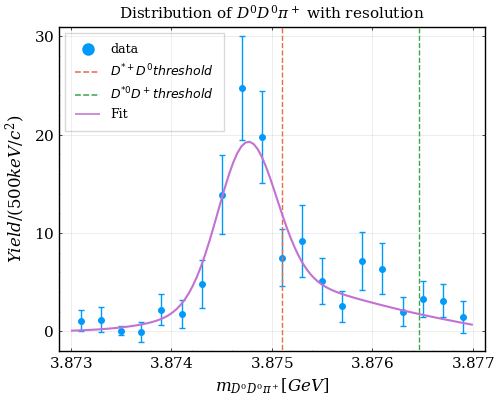

In [51]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [10144.361483353334,0.3961418693268329,0.0,0.0]), lw = 1.5, label = "Fit")
end

In [52]:
find_poles([0.3961418693268329,0.0,0.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, -2.4e-5]
 * Zero: [3.874749574830407, -2.4598529270966945e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [53]:
3.874749574830407-mDn-mDsc

-0.00035042516959338244

In [62]:
14.69/19

0.773157894736842

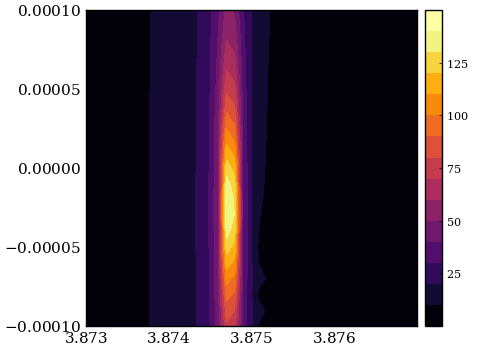

In [54]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.3961418693268329)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

In [55]:
14.69/(20-1)

0.773157894736842

In [58]:
print(fitres.errors)

PyObject <ErrorView N=1088.8164699385534 lam=0.0009692805508922098 cv=0.1 cp=0.1>

In [63]:
find_poles([0.3961418693268329+0.0009692805508922098,0.0,0.0])-find_poles([0.3961418693268329,0.0,0.0])

-1.8163189503983546e-5 + 3.0544666698204847e-7im

In [64]:
find_poles([0.3961418693268329-0.0009692805508922098,0.0,0.0])-find_poles([0.3961418693268329,0.0,0.0])

1.8285018412722565e-5 - 2.328926003819375e-7im

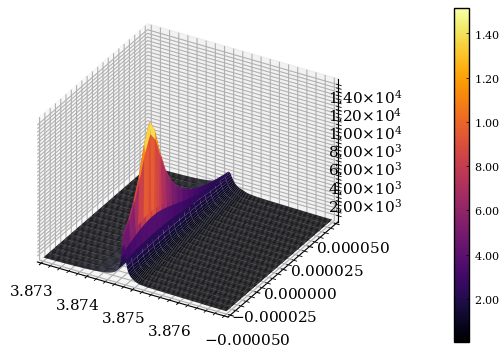

In [65]:
let Ev=collect(3.873:0.00002:3.877),Γv=collect(-50e-6:5e-6:50e-6)
    function tmpf(E)
        TMat!(E;Λ=0.3961418693268329)
        abs(Tmat[1,1])
    end
    resv=[real(tmpf(e+im*γ)) for γ in Γv,e in Ev]
    surface(Ev,Γv,resv)
end

# Get data

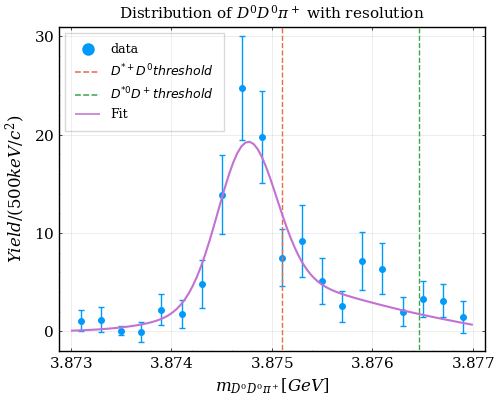

In [56]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [10144.361483353334,0.3961418693268329,0.0,0.0]), lw = 1.5, label = "Fit")
end

In [57]:
let Ev = range(3.873, 3.877, 100)
    yields=[dist(e, [10144.361483353334,0.3961418693268329,0.0,0.0]) for e in Ev]
    df=DataFrame(X=Ev,Y=yields)
    CSV.write("./output/fit3.csv",df)
end

"./output/fit3.csv"

# Test Lambda

In [27]:
fitresΛ=Array{Any}(undef,10);

In [31]:
for i in 1:10
    _n,_lam,_Cv,_Cp=[10000,0.3+0.1*(i-1),0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,100000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
    set!(tmp_model.fixed,"lam",true)
#     set!(tmp_model.fixed,"cp",true)
    fitresΛ[i]=piminuit.Minuit.migrad(tmp_model)
end

In [32]:
[fitresΛ[i].fval for i in 1:10]

10-element Vector{Float64}:
 72.89166562802315
 14.754237800144846
 15.110799994812362
 14.976861879124288
 65.66377325250721
 65.67158969613271
 65.68015258407164
 65.68449643482
 65.68965568423056
 65.69619318331407

In [33]:
[fitresΛ[i].values for i in 1:10]

10-element Vector{PyObject}:
 PyObject <ValueView N=16568.865734498067 lam=0.3 cv=2.7380390840250923e-07 cp=0.9999977909343823>
 PyObject <ValueView N=9891.463420859583 lam=0.4 cv=0.06044489449156236 cp=0.5310114035552814>
 PyObject <ValueView N=6268.643425457884 lam=0.5 cv=0.3959205584234702 cp=0.42559923638052116>
 PyObject <ValueView N=4831.806049911838 lam=0.6000000000000001 cv=0.5387126543822935 cp=0.05894677461055298>
 PyObject <ValueView N=30247.204804007044 lam=0.7 cv=0.4842605876068418 cp=0.07805903048620415>
 PyObject <ValueView N=25338.827811252613 lam=0.8 cv=0.546837383652907 cp=0.05013832218870556>
 PyObject <ValueView N=22255.536662970266 lam=0.9000000000000001 cv=0.6114082939014371 cp=0.44499779173553977>
 PyObject <ValueView N=20289.177831950743 lam=1.0 cv=0.6122476346691899 cp=0.2527954215130488>
 PyObject <ValueView N=19116.795490308356 lam=1.1 cv=0.6357285735813434 cp=0.46633820913620766>
 PyObject <ValueView N=18531.543306835967 lam=1.2 cv=0.6366007849630851 cp=0.45

In [41]:
fitresΛ[8]

PyObject <FMin algorithm='Migrad' edm=3.41652758013915e-05 edm_goal=0.0002 errordef=1.0 fval=65.68449643482 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=True has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=178 ngrad=0 reduced_chi2=nan time=3354.5930244440096>
(Param(number=0, name='N', value=20289.177831950743, error=4259.658814274859, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=100000.0), Param(number=1, name='lam', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.6122476346691899, error=0.10723866412041244, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.2527954215130488, error=0.7479989078658856, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 1.82129595e+07  0.00000000e+00 -2.81249129e+01 -1.89114503e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.81249129e+01  0.00000000e+00  1.16907795e-02  1.47184137e-01]
 [-1.89114503e+01  0.00000000e+00  1.47184137e-01  1.86861386e+00]]

In [42]:
find_poles([0.6,0.5387126543822935,0.05894677461055298])

-0.00034965507584372446 - 2.3150000479039063e-5im

In [44]:
fitresΛ[2]

PyObject <FMin algorithm='Migrad' edm=0.00011474344448691136 edm_goal=0.0002 errordef=1.0 fval=14.754237800144846 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=208 ngrad=0 reduced_chi2=nan time=4310.709689895011>
(Param(number=0, name='N', value=9891.463420859583, error=1103.8121955885908, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=100000.0), Param(number=1, name='lam', value=0.4, error=0.004, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.06044489449156236, error=0.07204188803129273, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.5310114035552814, error=0.7588927441142912, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 1.21895695e+06  0.00000000e+00 -5.81787468e+00 -5.24488084e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.81787468e+00  0.00000000e+00  5.35632582e-03  6.78945331e-02]
 [-5.24488084e+01  0.00000000e+00  6.78945331e-02  8.64704228e-01]]

In [52]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.6,0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,50000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
#     set!(tmp_model.fixed,"cv",true)
    set!(tmp_model.fixed,"lam",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=2.8795754525693727e-05 edm_goal=0.0002 errordef=1.0 fval=86.99901209448807 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=123 ngrad=0 reduced_chi2=nan time=6654.130121933005>
(Param(number=0, name='N', value=1177.2447647581412, error=354.74775407121916, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=50000.0), Param(number=1, name='lam', value=0.6, error=0.006, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.5075489222115505, error=0.014212302750022443, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.40500755420364987, error=0.17539352006860348, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 1.25937924e+05  0.00000000e+00 -6.34636478e-01 -4.97340676e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.34636478e-01  0.00000000e+00  2.02043985e-04  2.54028446e-03]
 [-4.97340676e+00  0.00000000e+00  2.54028446e-03  3.21691201e-02]]

In [53]:
fitres.values

PyObject <ValueView N=1177.2447647581412 lam=0.6 cv=0.5075489222115505 cp=0.40500755420364987>

In [54]:
find_poles([0.6,0.5075489222115505,0.40500755420364987])

-0.0009060139571794856 - 1.9771910577252334e-5im

In [55]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.5,0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,50000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
    set!(tmp_model.limits,"lam",(0.3,1.2))
#     set!(tmp_model.fixed,"cv",true)
#     set!(tmp_model.fixed,"lam",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=1.7949463487124908e-05 edm_goal=0.0002 errordef=1.0 fval=14.579266054806343 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=True has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=622 ngrad=0 reduced_chi2=nan time=17114.410824884995>
(Param(number=0, name='N', value=2965.749266471167, error=325.6728941501001, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=50000.0), Param(number=1, name='lam', value=1.1902530473426371, error=0.0027006184515341314, merror=None, is_const=False, is_fixed=False, lower_limit=0.3, upper_limit=1.2), Param(number=2, name='cv', value=0.6967488781065975, error=0.024217046124765385, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.013489546780068843, error=0.9855667940401891, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 1.06089727e+05 -1.78981760e-02 -1.15526458e-01  3.29950336e-01]
 [-1.78981760e-02  7.29538432e-06 -5.92630851e-08  1.60433791e-07]
 [-1.15526458e-01 -5.92630851e-08  5.87008734e-04  7.41794481e-03]
 [ 3.29950336e-01  1.60433791e-07  7.41794481e-03  9.41683930e-02]]

### more narrow

In [46]:
fitresΛ_na=Array{Any}(undef,9);

In [47]:
for i in 1:9
    _n,_lam,_Cv,_Cp=[10000,0.3+0.05*(i-1),0.01,0.01]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,100000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
    set!(tmp_model.fixed,"lam",true)
#     set!(tmp_model.fixed,"cp",true)
    fitresΛ_na[i]=piminuit.Minuit.migrad(tmp_model)
end

In [48]:
[fitresΛ_na[i].fval for i in 1:9]

9-element Vector{Float64}:
  72.89165490832102
  56.94456036855119
  14.74196835855941
 100.71514506914266
  65.63319173724909
  65.66156573363105
  14.980763045266198
  70.70721158614633
  71.07093262471516

In [50]:
[fitresΛ_na[i].values for i in 1:9]

9-element Vector{PyObject}:
 PyObject <ValueView N=16570.12191895528 lam=0.3 cv=4.738174287817476e-09 cp=0.9999999894356373>
 PyObject <ValueView N=8757.41485093256 lam=0.35 cv=1.4353345638776216e-10 cp=0.9999999999161582>
 PyObject <ValueView N=9883.84088202663 lam=0.4 cv=0.018746109199673348 cp=0.00031453626479285813>
 PyObject <ValueView N=958.6494829756989 lam=0.45 cv=0.0038229052260327708 cp=0.09730610299235591>
 PyObject <ValueView N=53281.34098423768 lam=0.5 cv=0.1196648447736021 cp=0.019344535551771732>
 PyObject <ValueView N=44633.02021702525 lam=0.55 cv=0.2578320142547009 cp=0.024086860811192108>
 PyObject <ValueView N=4832.589263915908 lam=0.6000000000000001 cv=0.5652638472051987 cp=0.39569203495084837>
 PyObject <ValueView N=99999.99838570596 lam=0.65 cv=0.20239450474657034 cp=0.0011293689928484163>
 PyObject <ValueView N=99999.98639260292 lam=0.7 cv=0.2443816939015877 cp=0.0013373923972767926>

### test cv

In [51]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.5,0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,50000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
#     set!(tmp_model.limits,"lam",(0.3,1.2))
#     set!(tmp_model.fixed,"cv",true)
    set!(tmp_model.fixed,"lam",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=1.7786549601000427e-05 edm_goal=0.0002 errordef=1.0 fval=15.110805171337843 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=289 ngrad=0 reduced_chi2=nan time=7558.912185517023>
(Param(number=0, name='N', value=6267.667092113914, error=693.562343897619, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=50000.0), Param(number=1, name='lam', value=0.5, error=0.005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.39594675430468645, error=0.03989530096341229, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.4258816415970404, error=0.6934158989698216, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 4.81310381e+05  0.00000000e+00 -2.12770244e+00 -2.06250465e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.12770244e+00  0.00000000e+00  1.59517827e-03  2.01803274e-02]
 [-2.06250465e+01  0.00000000e+00  2.01803274e-02  2.56469808e-01]]

In [52]:
fitres.values

PyObject <ValueView N=6267.667092113914 lam=0.5 cv=0.39594675430468645 cp=0.4258816415970404>

In [51]:
find_poles([0.5,0.39594675430468645,0.4258816415970404])

-0.00034897658840060686 - 2.2225040743497868e-5im

In [54]:
TMat!(mDn+mDsc-0.00034897658840060686 - 2.2225040743497868e-5im;Λ=0.5,Cv=0.39594675430468645,Cp=0.4258816415970404)

In [55]:
det(LinearAlgebra.I-Vmat*Gmat)

-8.375032747559562e-12 + 2.1621621823577305e-12im

In [57]:
size(Vmat)

(388, 388)

In [61]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11-v12*g22)
end

1.4869172919516866 - 0.08239822548247382im

In [62]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11+v12*g22)
end

0.03318337897498637 - 0.0029375785352068707im

# Test CV

In [31]:
length(0.0:0.05:1.0)

21

In [32]:
fitres_V=Array{Any}(undef,21);

In [33]:
for i in 1:21
    println(i)
    _n,_lam,_Cv,_Cp=[10000,0.4,0.05*(i-1),0.0]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(0,100000))
    set!(tmp_model.limits,"lam",(0.3,2.0))
    set!(tmp_model.fixed,"cp",true)
    set!(tmp_model.fixed,"cv",true)
#     set!(tmp_model.fixed,"cp",true)
    fitres_V[i]=piminuit.Minuit.migrad(tmp_model)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


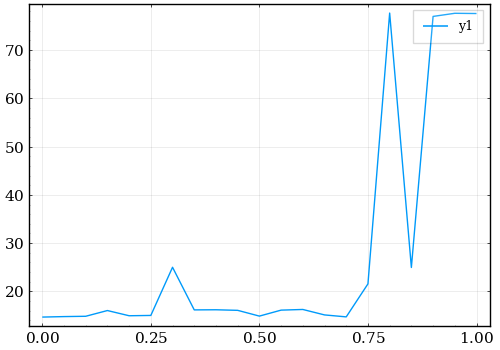

In [34]:
plot(collect(0.0:0.05:1.0),[fitres_V[i].fval for i in 1:21])

In [53]:
fitres_V[1].values[2]

0.39614568884480117

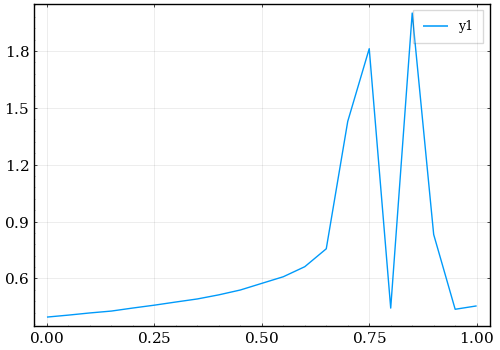

In [36]:
plot(collect(0.0:0.05:1.0),[fitres_V[i].values[2] for i in 1:21])

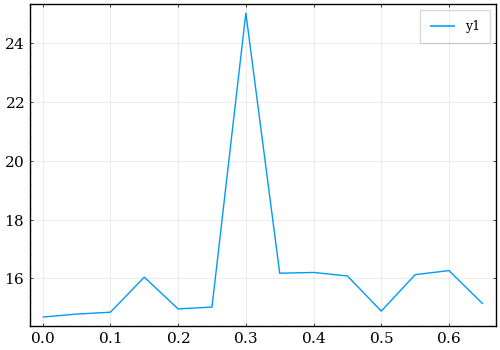

In [50]:
plot(collect(0.0:0.05:0.65),[fitres_V[i].fval for i in 1:14])

In [55]:
find_poles([fitres_V[11].values[2],fitres_V[11].values[3],fitres_V[11].values[4]])

-0.0003498151990855014 - 2.3543205296690043e-5im

In [56]:
find_poles([fitres_V[7].values[2],fitres_V[7].values[3],fitres_V[7].values[4]])

-0.00034695481815560925 - 2.263309394243554e-5im

In [70]:
fitres_V[6]

PyObject <FMin algorithm='Migrad' edm=4282.522453049145 edm_goal=0.0002 errordef=1.0 fval=15.030555927134689 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=True has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=False hesse_failed=False is_above_max_edm=True is_valid=False nfcn=307 ngrad=0 reduced_chi2=nan time=8980.547645329>
(Param(number=0, name='N', value=7353.399597604418, error=161.26579084216155, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=100000.0), Param(number=1, name='lam', value=0.45899907157404574, error=1.6054573548576867, merror=None, is_const=False, is_fixed=False, lower_limit=0.3, upper_limit=2.0), Param(number=2, name='cv', value=0.25, error=0.0025, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='cp', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[26006.98622808  1323.29024363     0.             0.        ]
 [ 1323.29024363    67.48804295     0.             0.        ]
 [    0.             0.             0.             0.        ]
 [    0.             0.             0.             0.        ]]

In [65]:
[fitres_V[i].valid for i in 1:21]

21-element Vector{Bool}:
 1
 1
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [73]:
fitres_V[6]

PyObject <FMin algorithm='Migrad' edm=4282.522453049145 edm_goal=0.0002 errordef=1.0 fval=15.030555927134689 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=True has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=False hesse_failed=False is_above_max_edm=True is_valid=False nfcn=307 ngrad=0 reduced_chi2=nan time=8980.547645329>
(Param(number=0, name='N', value=7353.399597604418, error=161.26579084216155, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=100000.0), Param(number=1, name='lam', value=0.45899907157404574, error=1.6054573548576867, merror=None, is_const=False, is_fixed=False, lower_limit=0.3, upper_limit=2.0), Param(number=2, name='cv', value=0.25, error=0.0025, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='cp', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[26006.98622808  1323.29024363     0.             0.        ]
 [ 1323.29024363    67.48804295     0.             0.        ]
 [    0.             0.             0.             0.        ]
 [    0.             0.             0.             0.        ]]

In [75]:
fcn(fitres_V[6].values[1],fitres_V[6].values[2],fitres_V[6].values[3],fitres_V[6].values[4])

15.030555927134689

In [76]:
 let   
    _n,_lam,_Cv,_Cp=[fitres_V[6].values[1],fitres_V[6].values[2],fitres_V[6].values[3],fitres_V[6].values[4]]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
#     set!(tmp_model.limits,"N",(0,10000))
#     set!(tmp_model.limits,"lam",(0.3,1.0))
    set!(tmp_model.fixed,"cp",true)
    set!(tmp_model.fixed,"cv",true)
#     set!(tmp_model.fixed,"cp",true)
    global fitres_add1=piminuit.Minuit.migrad(tmp_model)
end

PyObject <FMin algorithm='Migrad' edm=1.5785624051518924e-07 edm_goal=0.0002 errordef=1.0 fval=15.030508898954409 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=48 ngrad=0 reduced_chi2=nan time=2579.858529964011>
(Param(number=0, name='N', value=7353.399597604418, error=782.8661444010961, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='lam', value=0.4589977273922996, error=3.8769864840523964e-05, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.25, error=0.0025, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='cp', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[ 6.12879400e+05 -2.12502205e-04  0.00000000e+00  0.00000000e+00]
 [-2.12502205e-04  1.50310242e-09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

In [77]:
 let   
    _n,_lam,_Cv,_Cp=[fitres_V[7].values[1],fitres_V[7].values[2],fitres_V[7].values[3],fitres_V[7].values[4]]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
#     set!(tmp_model.limits,"N",(0,200000))
#     set!(tmp_model.limits,"lam",(0.0,3.0))
    set!(tmp_model.fixed,"cp",true)
    set!(tmp_model.fixed,"cv",true)
#     set!(tmp_model.fixed,"cp",true)
    global fitres_add2=piminuit.Minuit.migrad(tmp_model)
end

PyObject <FMin algorithm='Migrad' edm=2.661428457571048e-05 edm_goal=0.0002 errordef=1.0 fval=15.04988531979792 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=42 ngrad=0 reduced_chi2=nan time=900.9860300750006>
(Param(number=0, name='N', value=6888.346404969903, error=754.8586033318537, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='lam', value=0.4758234130379282, error=0.0010852334009793583, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.30000000000000004, error=0.0030000000000000005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='cp', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[5.69811511e+05 1.95743584e-01 0.00000000e+00 0.00000000e+00]
 [1.95743584e-01 1.17773153e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

In [78]:
fitres_V1=Array{Any}(undef,21);

In [79]:
for i in 1:21
    println(i)
    _n,_lam,_Cv,_Cp=[fitres_V[i].values[1],fitres_V[i].values[2],fitres_V[i].values[3],fitres_V[i].values[4]]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
#     set!(tmp_model.limits,"N",(0,100000))
#     set!(tmp_model.limits,"lam",(0.3,2.0))
    set!(tmp_model.fixed,"cp",true)
    set!(tmp_model.fixed,"cv",true)
#     set!(tmp_model.fixed,"cp",true)
    fitres_V1[i]=piminuit.Minuit.migrad(tmp_model)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


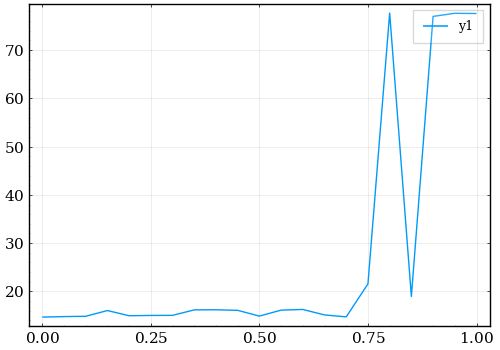

In [80]:
plot(collect(0.0:0.05:1.0),[fitres_V1[i].fval for i in 1:21])

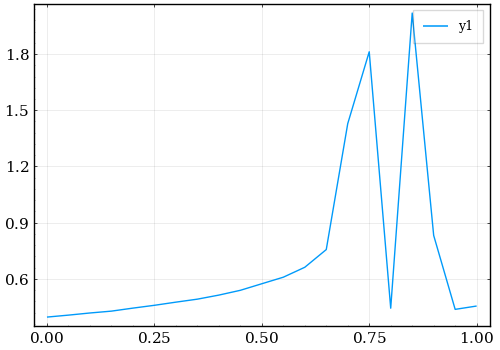

In [81]:
plot(collect(0.0:0.05:1.0),[fitres_V1[i].values[2] for i in 1:21])

In [95]:
df_CV=[]

Any[]

In [96]:
for i in 1:21
    push!(df_CV,[fitres_V1[i].values[2],fitres_V1[i].values[3],fitres_V1[i].values[4],fitres_V1[i].fval,fitres_V1[i].errors[2]])
end

In [97]:
df_CV

21-element Vector{Any}:
 [0.39614423150553135, 0.0, 0.0, 14.690689711775489, 0.0010707981712642458]
 [0.4065741694093018, 0.05, 0.0, 14.792452914056737, 9.354063425655389e-6]
 [0.418013022883916, 0.1, 0.0, 14.856465268501132, 0.0010697568456157866]
 [0.42790802566313124, 0.15000000000000002, 0.0, 16.044622817643138, 0.0009158801093720115]
 [0.44397576030779734, 0.2, 0.0, 14.967010913265197, 0.00103723794972203]
 [0.4589977273922996, 0.25, 0.0, 15.030508898954409, 3.8769864840523964e-5]
 [0.4758234130379282, 0.30000000000000004, 0.0, 15.04988531979792, 0.0010852334009793583]
 [0.4917912461488198, 0.35000000000000003, 0.0, 16.17875042015127, 0.001034123049219135]
 [0.5134659404277223, 0.4, 0.0, 16.204721948491724, 0.0012880296600943678]
 [0.5390053506810766, 0.45, 0.0, 16.085688604237845, 0.0012830347273627726]
 [0.5740550196890929, 0.5, 0.0, 14.893056546565, 0.00011961208133287077]
 [0.6089397415981808, 0.55, 0.0, 16.129589776831814, 0.0017253152024545048]
 [0.6619210014247019, 0.600000

In [98]:
CSV.write("./output/df_cv.csv",DataFrame(x=hcat(df_CV...)[1,:],y=hcat(df_CV...)[2,:],z=hcat(df_CV...)[3,:],l=hcat(df_CV...)[4,:],m=hcat(df_CV...)[5,:]))

"./output/df_cv.csv"

# Testing

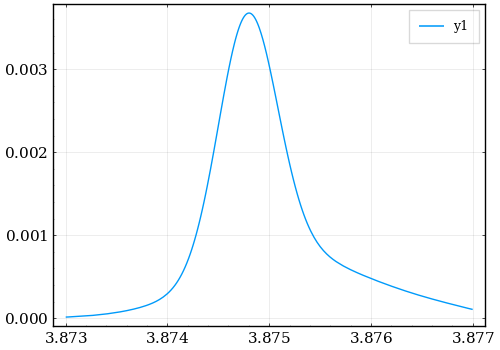

In [29]:
plot(e->dist(e,[1,0.5,0.3691804794959903,0.000286601099045658]),3.873,3.877)

In [30]:
30/0.003

10000.0

In [33]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.5,0.3691804794959903,0.000286601099045658]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(5000,12000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.fixed,"lam",true)
    set!(tmp_model.fixed,"cp",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=2.0284814380939524e-06 edm_goal=0.0002 errordef=1.0 fval=16.215716570465656 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=59 ngrad=0 reduced_chi2=nan time=418.65929604100165>
(Param(number=0, name='N', value=5624.5240192132005, error=924.620031010922, merror=None, is_const=False, is_fixed=False, lower_limit=5000.0, upper_limit=12000.0), Param(number=1, name='lam', value=0.5, error=0.005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.36987656409803527, error=0.0024296840935422725, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.000286601099045658, error=2.86601099045658e-06, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[9.24261627e+05 0.00000000e+00 1.81990735e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.81990735e+00 0.00000000e+00 5.90341464e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

In [34]:
fitres.values

PyObject <ValueView N=5624.5240192132005 lam=0.5 cv=0.36987656409803527 cp=0.000286601099045658>

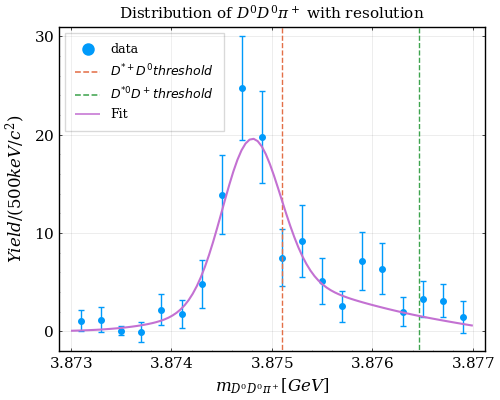

In [35]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(500keV/c^2)" label = "data" size = (500, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
    vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")
    plot!(Ev, e -> dist(e, [5624.5240192132005,0.5,0.36987656409803527,0.000286601099045658]), lw = 1.5, label = "Fit")
end

In [36]:
find_poles([0.5,0.36987656409803527,0.000286601099045658])

-0.00030652612087189723 - 2.2926210544825566e-5im

In [37]:
let 
    _n,_lam,_Cv,_Cp=[10000,0.5,0.5,0.5]
    tmp_model=piminuit.Minuit(fcn,N=_n,lam=_lam,cv=_Cv,cp=_Cp,name=("N","lam","cv","cp"))
    set!(tmp_model.limits,"N",(2000,20000))
    set!(tmp_model.limits,"cv",(0.0,1.0))
    set!(tmp_model.limits,"cp",(0.0,1.0))
    set!(tmp_model.fixed,"lam",true)
#     set!(tmp_model.fixed,"cp",true)
    global fitres=piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=1.6392672010897163e-05 edm_goal=0.0002 errordef=1.0 fval=15.110802145327312 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=300 ngrad=0 reduced_chi2=nan time=3084.626830833>
(Param(number=0, name='N', value=6268.127087037624, error=692.3355802656597, merror=None, is_const=False, is_fixed=False, lower_limit=2000.0, upper_limit=20000.0), Param(number=1, name='lam', value=0.5, error=0.005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.39593570184206545, error=0.03993025263416053, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.42577459778725796, error=0.6934772337565855, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 4.80640992e+05  0.00000000e+00 -2.07820419e+00 -2.00523838e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.07820419e+00  0.00000000e+00  1.59798079e-03  2.02166349e-02]
 [-2.00523838e+01  0.00000000e+00  2.02166349e-02  2.56939677e-01]]

In [39]:
arr=Array{Any}(undef,10)

10-element Vector{Any}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [40]:
arr[1]=fitres

PyObject <FMin algorithm='Migrad' edm=1.6392672010897163e-05 edm_goal=0.0002 errordef=1.0 fval=15.110802145327312 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=300 ngrad=0 reduced_chi2=nan time=3084.626830833>
(Param(number=0, name='N', value=6268.127087037624, error=692.3355802656597, merror=None, is_const=False, is_fixed=False, lower_limit=2000.0, upper_limit=20000.0), Param(number=1, name='lam', value=0.5, error=0.005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.39593570184206545, error=0.03993025263416053, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.42577459778725796, error=0.6934772337565855, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0))
[[ 4.80640992e+05  0.00000000e+00 -2.07820419e+00 -2.00523838e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.07820419e+00  0.00000000e+00  1.59798079e-03  2.02166349e-02]
 [-2.00523838e+01  0.00000000e+00  2.02166349e-02  2.56939677e-01]]

In [41]:
arr

10-element Vector{Any}:
    PyObject <FMin algorithm='Migrad' edm=1.6392672010897163e-05 edm_goal=0.0002 errordef=1.0 fval=15.110802145327312 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=300 ngrad=0 reduced_chi2=nan time=3084.626830833>
(Param(number=0, name='N', value=6268.127087037624, error=692.3355802656597, merror=None, is_const=False, is_fixed=False, lower_limit=2000.0, upper_limit=20000.0), Param(number=1, name='lam', value=0.5, error=0.005, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='cv', value=0.39593570184206545, error=0.03993025263416053, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=3, name='cp', value=0.42577459778725796, error=0.6934772337565855, merror=None, is_const=False, 